# Evaluating model and interpret the classification results

In [53]:
import torchray
import torch
import attr
from pathlib import Path
from torchvision import datasets, transforms
from torchray.benchmark import get_example_data, plot_example
from torchvision import models
import torchvision
import matplotlib.pyplot as plt

In [24]:
@attr.s(auto_attribs=True)
class DataPreparation:
    data_dir: Path
    device: str = attr.ib(default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), init=False)

    @staticmethod
    def data_transformations():
        data_transforms = {
            'test': transforms.Compose([
                transforms.Resize((224,224)),
        #         transforms.CenterCrop(800),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return data_transforms
    
    def create_dataloaders(self, batch_size, shuffle, num_workers):
        data_transforms = self.data_transformations()
        
        image_datasets = {
            'test': datasets.ImageFolder(self.data_dir, data_transforms['test'])
        }
        dataloaders = {
            'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        }
        dataset_sizes = {
            'test': len(image_datasets['test'])
        }
        return dataloaders, dataset_sizes


In [25]:
data_prep = DataPreparation('../data/figures/test')
data, size = data_prep.create_dataloaders(4, False, 4)

In [26]:
model_path = Path().cwd().parents[0] / "models/resnet50_d_27_t_14_15.pth"

In [27]:
model = torch.load(model_path)
model.eval();

In [28]:
for inputs, labels in data['test']:
    inputs = inputs.to(0)
    labels = labels.to(0)
    x = inputs
    print(x.size(), labels.size())
    break

torch.Size([4, 3, 224, 224]) torch.Size([4])


In [29]:
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency

In [15]:
saliency = grad_cam(model, x, 20, saliency_layer='features.29')

AssertionError: We could not find the saliency layer

In [45]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [31]:
x.size()

torch.Size([4, 3, 224, 224])

In [32]:
x.requires_grad_();
scores = model(x)

In [33]:
scores

tensor([[-0.1452,  0.1504],
        [-0.1371,  0.1419],
        [-0.1501,  0.1554],
        [-0.1294,  0.1340]], device='cuda:0', grad_fn=<AddmmBackward>)

In [34]:
score_max_index = scores.argmax(dim=1)
print(f"SCORE MAX INDEX: {score_max_index}")
score_max = scores[0,score_max_index]
print(f"SCORE MAX: {score_max}")

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward(torch.ones_like(score_max))
# score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(x.grad.data.abs(),dim=1)

SCORE MAX INDEX: tensor([1, 1, 1, 1], device='cuda:0')
SCORE MAX: tensor([0.1504, 0.1504, 0.1504, 0.1504], device='cuda:0',
       grad_fn=<IndexBackward>)


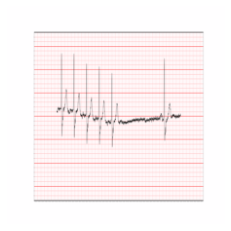

In [54]:
# code to plot the saliency map as a heatmap
plt.figure()
img1 = plt.imshow(saliency[0].cpu().numpy(), cmap=plt.cm.hot, alpha=.7)
img2 = plt.imshow(deprocess(x[0].cpu()))
plt.axis('off')
plt.show()

In [55]:
saliency.mean()

tensor(0.0006, device='cuda:0')

In [ ]:
m = models.alexnet(pretrained=True)